
# <center> CSCI 395 - Capstone Project Proposal<center>

### <center> José Miguel Ortiz
### <center> Hunter College <center>
### <center> CSCI 395: Introduction to Data Science <center>
### <center> Prof. Adrián Soto Cambres
### <center> Date: 04/06/2025


In [1]:
'''
Name: Jose Miguel Ortiz
Email: jose.ortiz60@lagcc.cuny.edu
Date: 04/06/2025
'''

'\nName: Jose Miguel Ortiz\nEmail: jose.ortiz60@lagcc.cuny.edu\nDate: 04/06/2025\n'

# NYC Subway Entrance Navigator: An Interactive Transit Information Tool

## 1. Overview

This project analyzes the accessibility of New York City's subway system by examining the distribution and characteristics of subway entrances and exits across the five boroughs. The analysis focuses on identifying areas with limited accessibility options, particularly for individuals with mobility challenges who require elevator access.

Key objectives include:
- Mapping the geographic distribution of accessible and non-accessible subway entrances
- Analyzing accessibility disparities across boroughs and subway lines
- Identifying high-traffic stations lacking adequate accessibility features
- Developing a prioritization framework for accessibility improvements

The project aims to provide actionable insights for urban planners, transit advocates, and policymakers working to improve subway accessibility for all New Yorkers.

## 2. Background

New York City's subway system is one of the largest and oldest public transportation networks in the world, serving millions of residents and visitors daily. However, the system's age and design present significant accessibility challenges. According to the MTA, only about 25% of the city's subway stations are fully accessible to people with disabilities, far below other major transit systems worldwide.

**System Complexity:**
- 472 stations across 36 lines
- Over 2,000 entrance and exit points
- Multiple entrance types (stairs, elevators, escalators)
- Varying levels of ADA compliance

**Legal and Policy Context:**
The Americans with Disabilities Act (ADA) requires public transportation systems to be accessible to people with disabilities. However, many of NYC's subway stations were built before these requirements, and the MTA has faced ongoing legal challenges regarding accessibility improvements.

**Recent Developments:**
In 2022, the MTA committed to making 95% of subway stations accessible by 2055 as part of a settlement with disability rights advocates. This project aims to contribute to this effort by providing data-driven insights on where improvements are most needed.

## 3. Data Sources

This project utilizes the MTA Subway Entrances and Exits dataset (2024), which provides detailed information about each subway entrance and exit in the NYC system.

**Dataset:** [MTA Subway Entrances and Exits (2024)](https://data.ny.gov/Transportation/MTA-Subway-Entrances-and-Exits-2024/i9wp-a4ja/about_data)

**Key Fields:**

| Category | Example Fields |
|----------|----------------|
| Location | Borough, Stop Name, Entrance Latitude, Entrance Longitude |
| Access Type | Entrance Type (Stair, Elevator, Escalator, etc.), Entry/Exit Allowed |
| Routes | Daytime Routes, Division, Line |
| Station Info | Station ID, GTFS Stop ID, Complex ID |


## 4. Exploratory Analysis

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Load the dataset
file_path = 'MTA_Subway_Entrances_and_Exits__2024_20250418.csv'
subway_entrances = pd.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {subway_entrances.shape}")
subway_entrances.info()

Dataset shape: (2120, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Division                  2120 non-null   object 
 1   Line                      2120 non-null   object 
 2   Borough                   2120 non-null   object 
 3   Stop Name                 2120 non-null   object 
 4   Complex ID                2120 non-null   int64  
 5   Constituent Station Name  2120 non-null   object 
 6   Station ID                2120 non-null   int64  
 7   GTFS Stop ID              2120 non-null   object 
 8   Daytime Routes            2120 non-null   object 
 9   Entrance Type             2120 non-null   object 
 10  Entry Allowed             2120 non-null   object 
 11  Exit Allowed              2120 non-null   object 
 12  Entrance Latitude         2120 non-null   float64
 13  Entrance Longitude        2120 non-nu

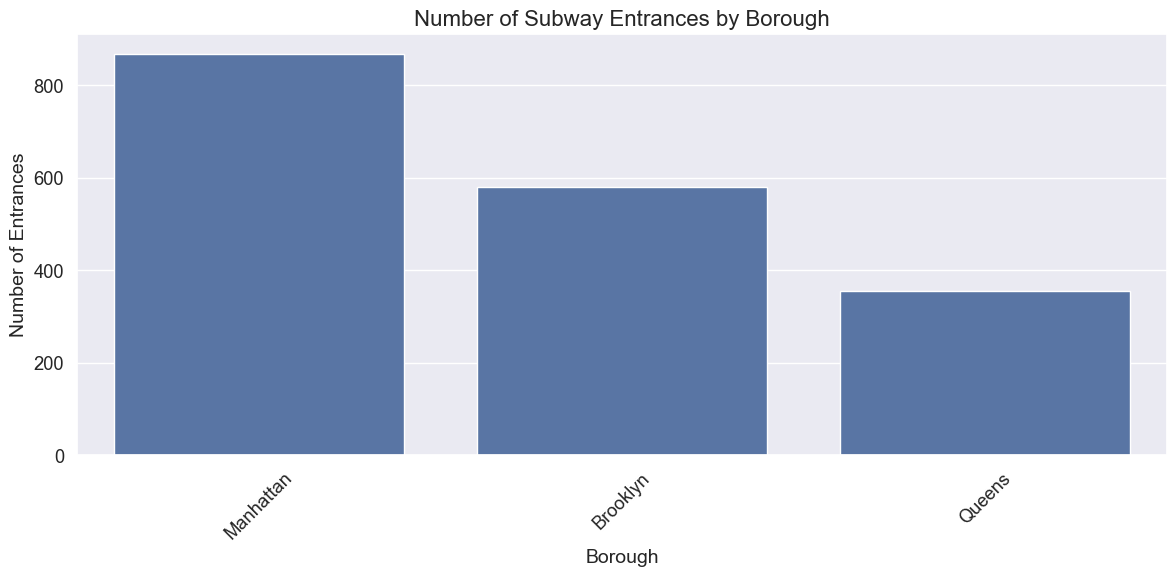

In [3]:
# Clean and prepare the data
# Convert borough codes to full names for better readability
borough_mapping = {
    'M': 'Manhattan',
    'B': 'Brooklyn',
    'Q': 'Queens',
    'X': 'Bronx',
    'S': 'Staten Island'
}

# Apply the mapping
subway_entrances['Borough_Name'] = subway_entrances['Borough'].map(borough_mapping)

# Create a binary column for elevator access
subway_entrances['Has_Elevator'] = subway_entrances['Entrance Type'].str.contains('Elevator', case=False).astype(int)

# Count entrances by borough
borough_counts = subway_entrances['Borough_Name'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=borough_counts.index, y=borough_counts.values)
plt.title('Number of Subway Entrances by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Number of Entrances', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

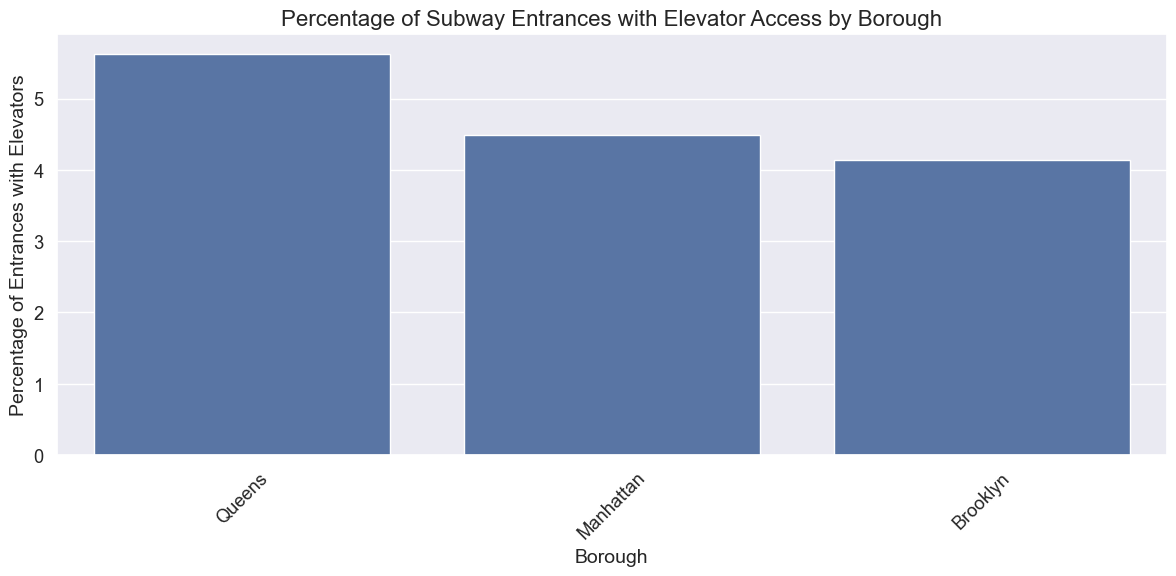

In [4]:
# Analyze elevator access by borough
elevator_by_borough = subway_entrances.groupby('Borough_Name')['Has_Elevator'].sum().reset_index()
total_by_borough = subway_entrances.groupby('Borough_Name').size().reset_index(name='Total')

# Merge the two dataframes
elevator_analysis = pd.merge(elevator_by_borough, total_by_borough, on='Borough_Name')
elevator_analysis['Percentage'] = (elevator_analysis['Has_Elevator'] / elevator_analysis['Total'] * 100).round(2)

# Sort by percentage of elevators
elevator_analysis = elevator_analysis.sort_values('Percentage', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Borough_Name', y='Percentage', data=elevator_analysis)
plt.title('Percentage of Subway Entrances with Elevator Access by Borough', fontsize=16)
plt.xlabel('Borough', fontsize=14)
plt.ylabel('Percentage of Entrances with Elevators', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

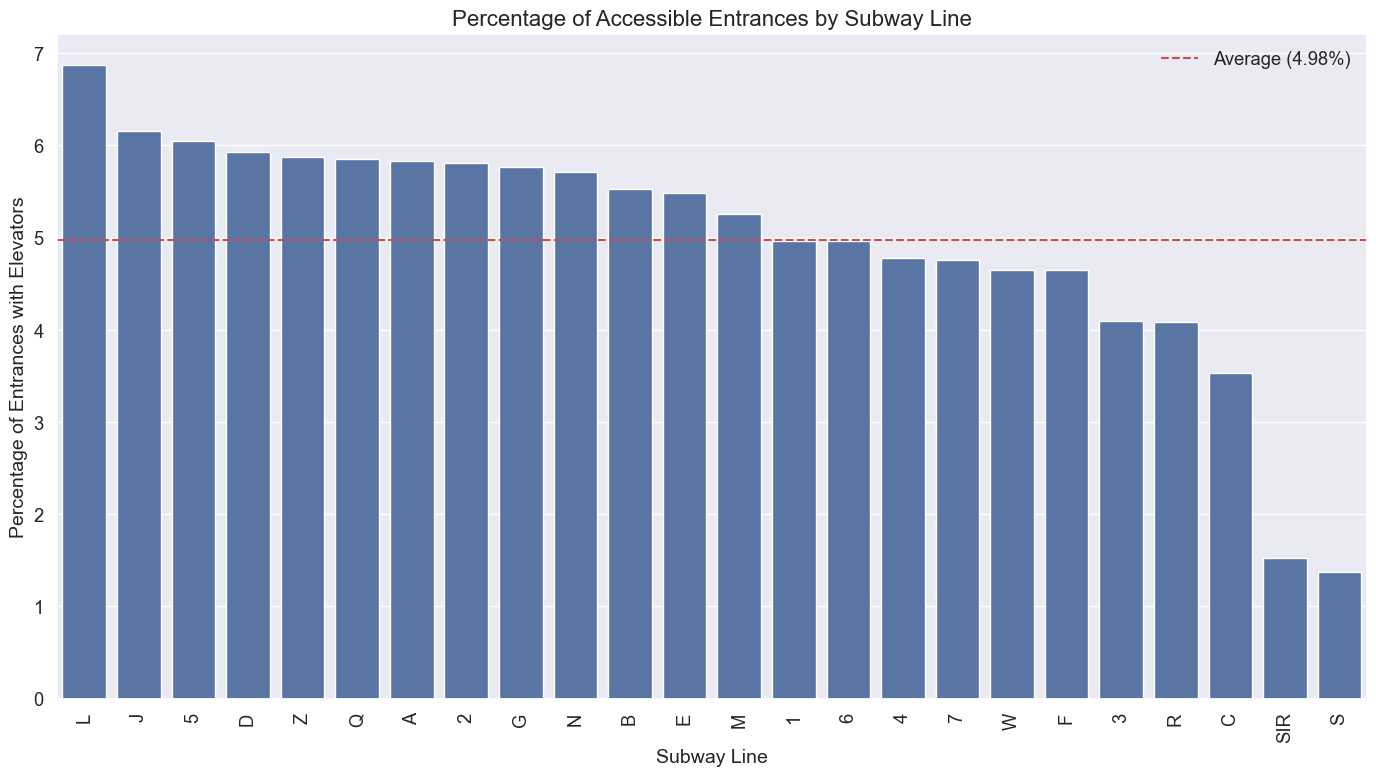

In [5]:
# Analyze subway lines and their accessibility
# First, we need to explode the Daytime Routes column since it contains multiple lines per entry
# Create a copy of the dataframe with only the columns we need
routes_df = subway_entrances[['Daytime Routes', 'Has_Elevator', 'Stop Name']].copy()

# Split the routes into separate rows
routes_df['Daytime Routes'] = routes_df['Daytime Routes'].str.split()
routes_exploded = routes_df.explode('Daytime Routes')

# Group by route and calculate accessibility metrics
route_accessibility = routes_exploded.groupby('Daytime Routes').agg(
    total_entrances=('Stop Name', 'count'),
    elevator_entrances=('Has_Elevator', 'sum')
).reset_index()

# Calculate percentage of accessible entrances
route_accessibility['accessibility_percentage'] = (route_accessibility['elevator_entrances'] /
                                                 route_accessibility['total_entrances'] * 100).round(2)

# Sort by accessibility percentage
route_accessibility = route_accessibility.sort_values('accessibility_percentage', ascending=False)

# Visualize the accessibility percentage by subway line
plt.figure(figsize=(14, 8))
sns.barplot(x='Daytime Routes', y='accessibility_percentage', data=route_accessibility)
plt.title('Percentage of Accessible Entrances by Subway Line', fontsize=16)
plt.xlabel('Subway Line', fontsize=14)
plt.ylabel('Percentage of Entrances with Elevators', fontsize=14)
plt.xticks(rotation=90)
plt.axhline(y=route_accessibility['accessibility_percentage'].mean(), color='r', linestyle='--',
            label=f'Average ({route_accessibility["accessibility_percentage"].mean():.2f}%)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Product

The final product of this project will be a comprehensive NYC Subway Accessibility Dashboard that combines data analysis, visualization, and interactive mapping to provide insights into subway accessibility across the city.

### Key Components:

**1. Interactive Map Interface**
```python
import folium
from folium.plugins import MarkerCluster

# Create a map of subway entrances
# Center the map on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Create a marker cluster for better performance with many points
marker_cluster = MarkerCluster().add_to(nyc_map)

# Add markers for each entrance
for idx, row in subway_entrances.iterrows():
    # Skip if missing coordinates
    if pd.isna(row['Entrance Latitude']) or pd.isna(row['Entrance Longitude']):
        continue

    # Determine marker color based on elevator access
    color = 'green' if row['Has_Elevator'] == 1 else 'red'

    # Create popup text
    popup_text = f"<b>Station:</b> {row['Stop Name']}<br>"
    popup_text += f"<b>Entrance Type:</b> {row['Entrance Type']}<br>"
    popup_text += f"<b>Routes:</b> {row['Daytime Routes']}"

    # Add marker to cluster
    folium.Marker(
        location=[row['Entrance Latitude'], row['Entrance Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=color, icon='subway', prefix='fa')
    ).add_to(marker_cluster)
```

**2. Accessibility Gap Analysis Tool**
```python
# Group by station to identify stations with no elevator access
station_accessibility = subway_entrances.groupby('Stop Name').agg(
    total_entrances=('Entrance Type', 'count'),
    elevator_entrances=('Has_Elevator', 'sum'),
    borough=('Borough_Name', 'first'),
    routes=('Daytime Routes', 'first')
).reset_index()

# Identify stations with no elevator access
inaccessible_stations = station_accessibility[station_accessibility['elevator_entrances'] == 0]

# Sort by total entrances to find the busiest inaccessible stations
inaccessible_stations = inaccessible_stations.sort_values('total_entrances', ascending=False)
```

**3. Prioritization Framework**
The dashboard will include a prioritization model that considers:
- Station ridership data
- Demographic information of surrounding neighborhoods
- Proximity to essential services (hospitals, government offices, etc.)
- Existing accessible stations in the vicinity

**4. Equity Analysis Module**
This component will analyze the relationship between subway accessibility and demographic factors such as:
- Income levels
- Population density
- Percentage of elderly residents
- Percentage of residents with disabilities

### Implementation Plan:

1. **Data Processing Pipeline**
   - Clean and integrate MTA data with demographic information
   - Calculate accessibility metrics for stations, lines, and neighborhoods

2. **Dashboard Development**
   - Build interactive map using Folium or Plotly
   - Create data visualization components with Matplotlib and Seaborn
   - Develop filtering and search capabilities

3. **Analysis Modules**
   - Implement gap analysis algorithms
   - Develop prioritization scoring system
   - Create equity analysis tools

4. **Documentation and Deployment**
   - Create user guide and technical documentation
   - Deploy dashboard as a web application
   - Prepare presentation materials for stakeholders